In [62]:
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain.agents import Tool
from langchain.prompts import PromptTemplate
from langchain.agents import AgentExecutor, create_react_agent
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
from dotenv import load_dotenv

In [63]:
load_dotenv()

True

In [64]:
llm = ChatGoogleGenerativeAI(model="gemma-3-4b-it")
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

### Simple Workflow with Graph

In [65]:
def function3(input):
    return input

In [66]:
def function1(input1):
    return input1 + " from first function"

def function2(input2):
    func3_output = function3(", this is the function 3 in between")
    return input2 + func3_output +" and from Audii second function"


In [67]:
from langgraph.graph import Graph

In [68]:
workflow1 = Graph()

In [69]:
#adding nodes to the workflow

workflow1.add_node("function1", function1)
workflow1.add_node("function2", function2)

In [70]:
# add starting point and end point

workflow1.set_entry_point("function1")
# adding edges to the workflow
workflow1.add_edge("function1", "function2")
workflow1.set_finish_point("function2")

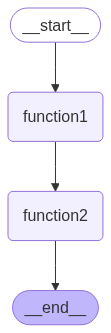

In [71]:
app1 = workflow1.compile()
app1

In [72]:
app1.invoke("Hii this vedant")

'Hii this vedant from first function, this is the function 3 in between and from Audii second function'

### Workflow with an llm

In [73]:
llm.invoke("hi").content

'Hi there! How’s your day going so far? Is there anything you’d like to chat about, or were you just saying hello? 😊'

In [74]:
def function1(input):
    response = llm.invoke(input)
    return response.content

In [75]:
def function2(input):
    upper_case = input.upper()
    return upper_case

In [76]:
workflow2 = Graph()

In [77]:
workflow2.add_node("llm", function1)
workflow2.add_node("upper_string", function2)

In [78]:
workflow2.set_entry_point("llm")
workflow2.add_edge("llm", "upper_string")
workflow2.set_finish_point("upper_string")

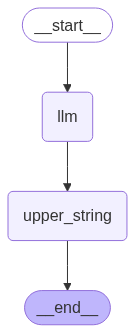

In [79]:
app2 = workflow2.compile()
app2

In [80]:
result = app2.invoke("What is the name of Indian Prime Minister?")
print(result)

THE CURRENT PRIME MINISTER OF INDIA IS **NARENDRA MODI**. 

DO YOU WANT TO KNOW ANYTHING MORE ABOUT HIM OR THE INDIAN GOVERNMENT?


### Workflow with RAG

In [81]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langgraph.graph import Graph

In [82]:
loader=DirectoryLoader("data",glob="./*.txt",loader_cls=TextLoader)
docs=loader.load()
text_splitter=RecursiveCharacterTextSplitter(
    chunk_size=100,
    chunk_overlap=50
)
new_docs = text_splitter.split_documents(documents=docs)
doc_strings = [doc.page_content for doc in new_docs]

db = Chroma.from_documents(new_docs, embeddings)

retriever = db.as_retriever(search_kwargs={"k": 3})

query = "what is meta llama3?"
docs = retriever.get_relevant_documents(query)
print(docs[0].metadata)
print(docs[0].page_content)

for doc in docs:
    print(doc)

{'source': 'data/llama.txt'}
Alongside the release of Llama 3, Meta added virtual assistant features to Facebook and WhatsApp in
page_content='Alongside the release of Llama 3, Meta added virtual assistant features to Facebook and WhatsApp in' metadata={'source': 'data/llama.txt'}
page_content='Alongside the release of Llama 3, Meta added virtual assistant features to Facebook and WhatsApp in' metadata={'source': 'data/llama.txt'}
page_content='by Meta AI starting in February 2023.[2][3] The latest version is Llama 3 released in April' metadata={'source': 'data/llama.txt'}


In [83]:
def function1(AgentState):
    message = AgentState['messages']
    question = message[-1]

    complete_prompt = "Your task is to provide only the brief answer based on the user query.\
    Don't include too much reasoning. following is the user query: " + question

    response = llm.invoke(complete_prompt)

    AgentState['messages'].append(response.content)

    return AgentState    

In [84]:
def function2(AgentState):
    messages = AgentState['messages']
    question = messages[0]

    template = """Answer the question based only on the following context:
    {context}

    Question: {question}
    """

    prompt = ChatPromptTemplate.from_template(template)

    retrieval_chain = (
        {'context': retriever, 'question': RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
    )

    result = retrieval_chain.invoke(question)
    return result


In [85]:
workflow4 = Graph()

workflow4.add_node('llm', function1)
workflow4.add_node('Rag_tool', function2)
workflow4.set_entry_point('llm')
workflow4.add_edge('llm', 'Rag_tool')
workflow4.set_finish_point('Rag_tool')

app4 = workflow4.compile()

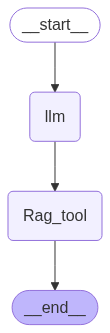

In [86]:
app4

In [87]:
inputs = {"messages": ['Tell me about the Llama3 model.']}

In [88]:
res = app4.invoke(inputs)
print(res)

The 8B parameter version of Llama 3 is being described as “surprisingly capable” given its size. Llama models have also been compared favorably against other large language models.


### LLM or RAG call

In [89]:
loader2=DirectoryLoader("data2",glob="./*.txt",loader_cls=TextLoader)
docs2=loader2.load()

text_splitter=RecursiveCharacterTextSplitter(
    chunk_size=100,
    chunk_overlap=50
)
 
new_docs2 = text_splitter.split_documents(documents=docs2)
doc_strings2 = [doc.page_content for doc in new_docs2]

In [92]:
db2 = Chroma.from_documents(new_docs2, embeddings)

retriever2 = db2.as_retriever(search_kwargs={"k": 3})

query = "Tell me about the India's Industrial Growth.."
docs = retriever2.get_relevant_documents(query)
print(docs[0].metadata)
print(docs[0].page_content)

for doc in docs:
    print(doc)

{'source': 'data2/indian_economy.txt'}
India’s strong export sectors—including textiles, IT services, and automotive manufacturing—had
page_content='India’s strong export sectors—including textiles, IT services, and automotive manufacturing—had' metadata={'source': 'data2/indian_economy.txt'}
page_content='India’s strong export sectors—including textiles, IT services, and automotive manufacturing—had' metadata={'source': 'data2/indian_economy.txt'}
page_content='India’s strong export sectors—including textiles, IT services, and automotive manufacturing—had' metadata={'source': 'data2/indian_economy.txt'}


In [93]:
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage
from langchain.prompts import PromptTemplate

In [94]:
class AgentState(TypedDict):

    messages: Annotated[Sequence[BaseMessage],operator.add]

In [95]:
from pydantic import BaseModel, Field

class TopicSelectionParser(BaseModel):

    Topic: str = Field(description="Selected Topic")
    Reasoning: str = Field(description="Reason behind the selected topic.")


In [96]:
from langchain.output_parsers import PydanticOutputParser
parser = PydanticOutputParser(pydantic_object=TopicSelectionParser)

In [97]:
print(parser.get_format_instructions())

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"properties": {"Topic": {"description": "Selected Topic", "title": "Topic", "type": "string"}, "Reasoning": {"description": "Reason behind the selected topic.", "title": "Reasoning", "type": "string"}}, "required": ["Topic", "Reasoning"]}
```


In [98]:
def function_1(State):

    message = State['messages']
    question = message[-1]

    template = """Your task is to classify the given user query in one of the following category: [India, Not Related].
    Only respond with the category name and nothing else.
    
    User Query: {question}
    {format_instructions}
    """

    prompt = PromptTemplate(template=template, 
                            input_variables=[question],
                            partial_variables={
                                "format_instructions": parser.get_format_instructions()
                            })
    
    chain = prompt | llm | parser
    response = chain.invoke({'question': question, 'format_instructions': parser.get_format_instructions()})

    print(response)

    return {'messages': [response.Topic]}

In [99]:
state = {"messages": ["Tell me about India's Industrial Growth."]}

In [100]:
function_1(state)

Topic='India' Reasoning='The query specifically asks about "India\'s Industrial Growth".'


{'messages': ['India']}

In [101]:
def router(state):
    print("-> Router ->")

    messages = state['messages']
    last_message = messages[-1]

    print(last_message)
    if "India" in last_message:
        return "RAG Call"
    else:
        return "LLM Call"
    

In [102]:
# RAG Function:

def function_2(State):

    print("Calling RAG...")
    messages = State['messages']
    question = messages[0]

    print(question)

    template = """Answer the question based only on the following context:
    {context}

    Question: {question}
    """

    prompt = ChatPromptTemplate.from_template(template)

    retrieval_chain = (
        {'context': retriever, 'question': RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
    )

    result = retrieval_chain.invoke(question)
    return {"messages": [result]}


In [103]:
# LLM Call

def function_3(state):

    print("Calling LLM...")

    messages = state['messages']
    question = messages[-1]

    complete_query = "Answer the following question with your own knowledge. Following is the user question: " + question
    response = llm.invoke(complete_query)
    
    return {'messages': response.content}

In [108]:
from langgraph.graph import StateGraph, END

workflow5 = Graph()

workflow5.add_node('agent', function_1)
workflow5.add_node('RAG', function_2)
workflow5.add_node('LLM', function_3)

workflow5.set_entry_point('agent')

workflow5.add_conditional_edges(
    'agent',
    router,
    {
        "RAG Call": "RAG",
        "LLM Call": "LLM"
    }
)

workflow5.add_edge('RAG', END)
workflow5.add_edge('LLM', END)

app5 = workflow5.compile()

In [114]:
# Test the workflow with a sample query
inputs = {"messages": ["Tell me about china total population."]} 
result = app5.invoke(inputs)
print(result["messages"])

Topic='Not Related' Reasoning='The query asks about the population of China, which is not related to India.'
-> Router ->
Not Related
Calling LLM...
Okay! Since you've indicated "Not Related," I understand you're not looking for a specific answer to a question. 

Essentially, you're letting me know that my previous response (or any potential response) isn't relevant to what you need. 

Is there anything *you* would like me to do instead? Perhaps you'd like me to:

*   **Just acknowledge you:** "Okay, understood. Let me know if you need anything else."
*   **Start a new conversation:** "What can I help you with?"
*   **Do something completely different** (like tell a joke, write a poem, or generate a random fact)?
Okay! Since you've indicated "Not Related," I understand you're not looking for a specific answer to a question. 

Essentially, you're letting me know that my previous response (or any potential response) isn't relevant to what you need. 

Is there anything *you* would like me